Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from glob import glob

In [10]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [11]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [12]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

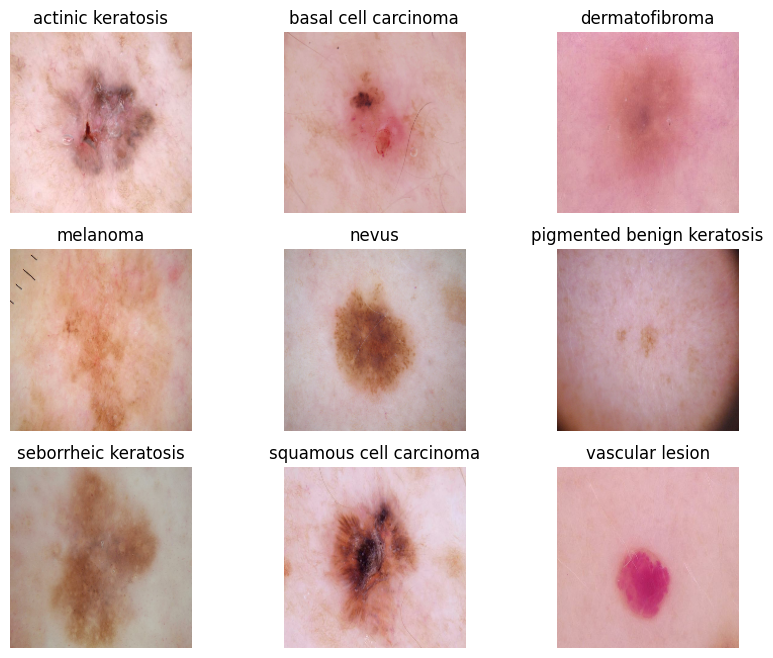

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
num_classes = len(class_names)

for i in range(num_classes):
  filtered_data = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for img, label in filtered_data.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [22]:
### Your code goes here
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout

# CNN Model Architecture

model = Sequential()
# Rescaling of pixel values between 0 and 1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
#Conv Layer - 1
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(180, 180, 3)))
# Max Pooling layer
model.add(MaxPooling2D())
# Conv Layer - 2
model.add(Conv2D(32, (3, 3), activation='relu'))
# Max Pooling layer
model.add(MaxPooling2D())
# Conv Layer - 3
model.add(Conv2D(64, (3, 3), activation='relu'))
# Max Pooling layer
model.add(MaxPooling2D())
# Flatten
model.add(Flatten())
# Dense layer
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [23]:
### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)       

### Train the model

In [25]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 179s 3s/step - loss: 2.0152 - accuracy: 0.2679 - val_loss: 1.7263 - val_accuracy: 0.4273
Epoch 2/20
56/56 [==============================] - 54s 970ms/step - loss: 1.6090 - accuracy: 0.4325 - val_loss: 1.6855 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 59s 1s/step - loss: 1.4354 - accuracy: 0.4855 - val_loss: 1.4008 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 62s 1s/step - loss: 1.3060 - accuracy: 0.5312 - val_loss: 1.3708 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 54s 975ms/step - loss: 1.2364 - accuracy: 0.5597 - val_loss: 1.3653 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 52s 929ms/step - loss: 1.1611 - accuracy: 0.5759 - val_loss: 1.4301 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 56s 990ms/step - loss: 1.0852 - accuracy: 0.6166 - val_loss: 1.4275 - val_accuracy: 0.5503
Epoch 8

### Visualizing training results

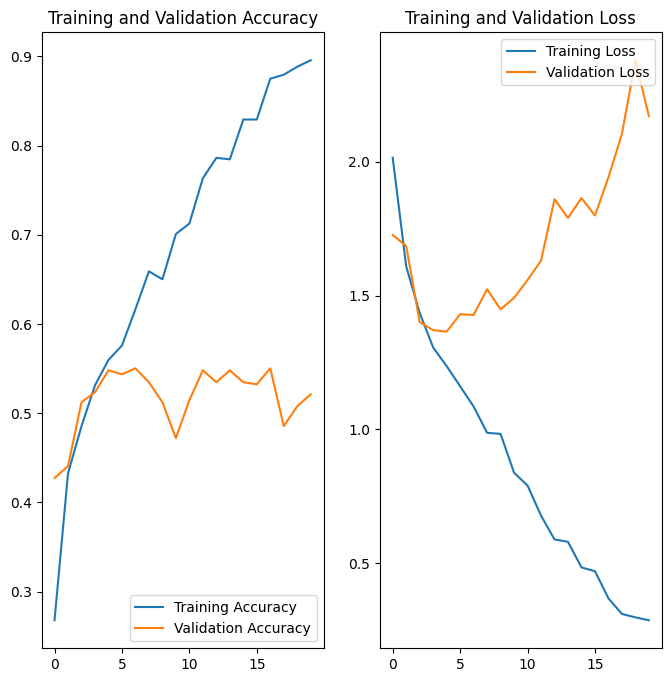

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here


### Findings
#### 1. Traning accuracy the model around 89 %
#### 2. Validation accuracy the model around 52 %
#### 3. There is major difference between Traning accuracy and Validation accuracy. It is clearly showing the overfitting.
#### 4. Data Augmentation and Dropout required to handle the overfitting issue of the model.


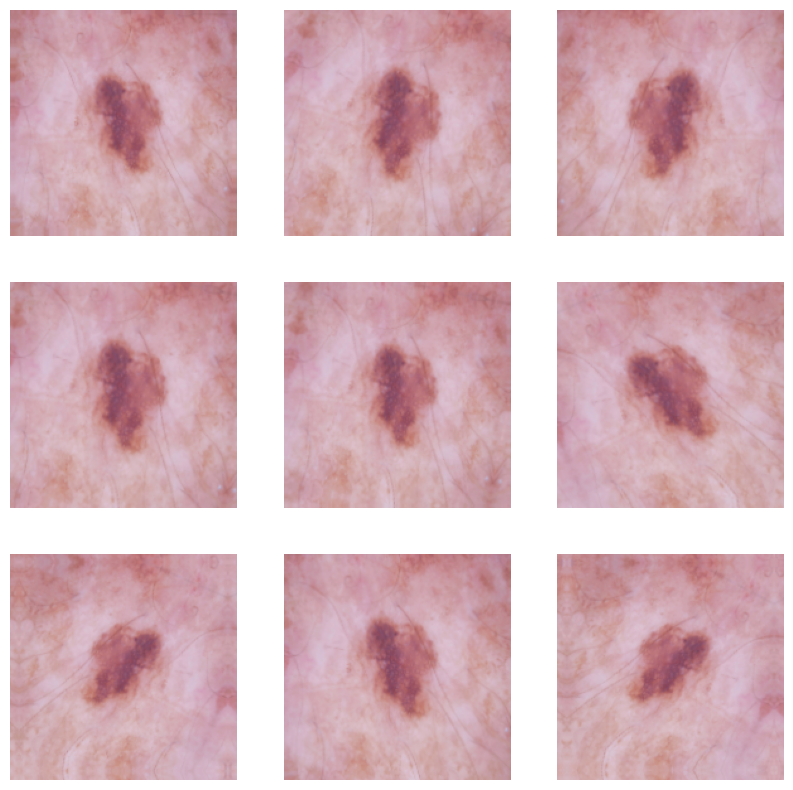

In [28]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [54]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()
# Rescaling of pixel values between 0 and 1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
#Conv Layer - 1
model.add(Conv2D(16, 3, padding='same', activation='relu'))
# Max Pooling layer
model.add(MaxPooling2D())
# Conv Layer - 2
model.add(Conv2D(32, 3, padding='same', activation='relu'))
# Max Pooling layer
model.add(MaxPooling2D())
# Conv Layer - 3
model.add(Conv2D(64, 3, padding='same', activation='relu'))
# Max Pooling layer
model.add(MaxPooling2D())
# Dropout layer with 0.2 drop rate
model.add(layers.Dropout(0.2))
# Flatten
model.add(Flatten())
# Dense layer
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))





### Compiling the model

In [55]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [56]:
## with the dropout layer checking the overfitting
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
169/169 [==============================] - 229s 1s/step - loss: 1.9335 - accuracy: 0.2719 - val_loss: 1.6320 - val_accuracy: 0.3987
Epoch 2/5
169/169 [==============================] - 224s 1s/step - loss: 1.4168 - accuracy: 0.4633 - val_loss: 1.3244 - val_accuracy: 0.4922
Epoch 3/5
169/169 [==============================] - 225s 1s/step - loss: 1.2164 - accuracy: 0.5549 - val_loss: 1.2346 - val_accuracy: 0.5434
Epoch 4/5
169/169 [==============================] - 225s 1s/step - loss: 1.0790 - accuracy: 0.6039 - val_loss: 1.1903 - val_accuracy: 0.5553
Epoch 5/5
169/169 [==============================] - 223s 1s/step - loss: 0.9594 - accuracy: 0.6500 - val_loss: 1.1766 - val_accuracy: 0.5887


### Visualizing the results

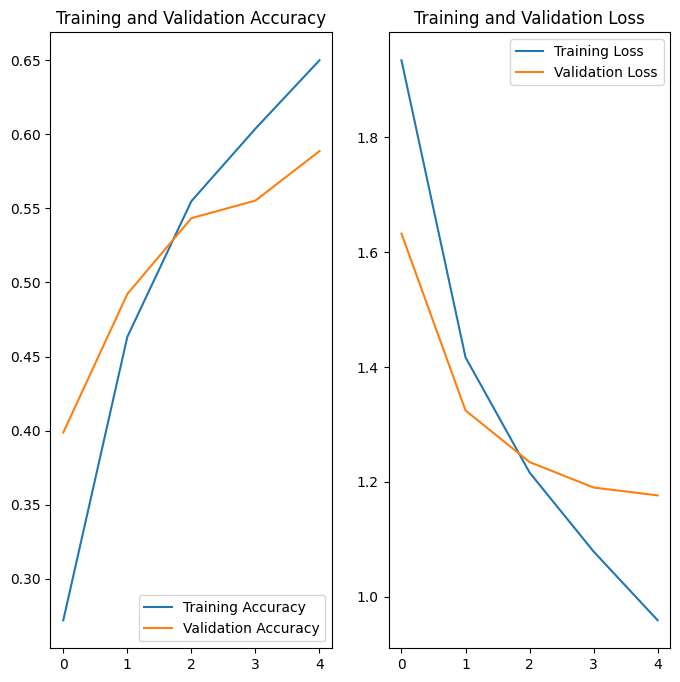

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Finding

### Findings
####  There is major difference between Traning accuracy and Validation accuracy.
#### 1. Traning accuracy the model around 65 %
#### 2. Validation accuracy the model around 58 %
#### 3. With the limited epoches the result looks fine but still the accuracies are very low. Augmentation, Batch normalaization and drop out improve it.



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [32]:
## Your code goes here.

path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df.head()

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
1,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
3,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
4,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion


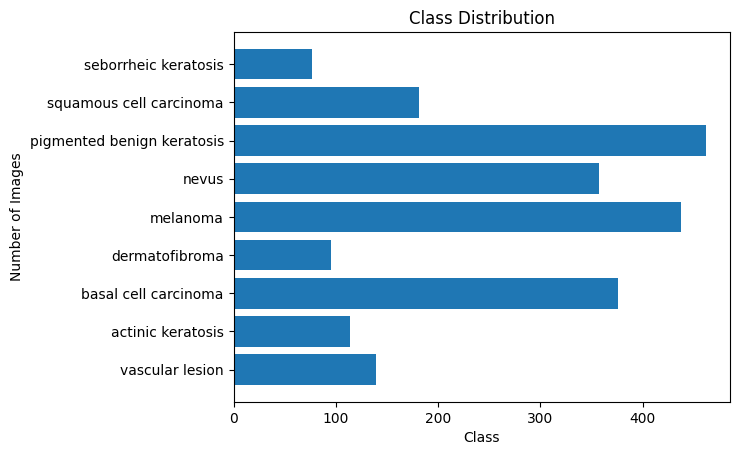

In [34]:
class_distribution = {}
for path in data_dir_train.iterdir():
    if path.is_dir():
        class_name = path.name
        class_distribution[class_name] = len(list(path.iterdir()))

# Create a bar chart
plt.barh(list(class_distribution.keys()), list(class_distribution.values()))
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

#### **Todo:** Write your findings here:
####- Which class has the least number of samples?
### Ans : From the above bar chart, class with label seborrheic keratosis has the least number of samples

###- Which classes dominate the data in terms proportionate number of samples?
### Ans:  From the above bar chart, class with label pigmented benign keratosis has the most number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EEBC52B640>: 100%|██████████| 500/500 [00:35<00:00, 14.01 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EEBCC26920>: 100%|██████████| 500/500 [00:39<00:00, 12.70 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79EEBC557BB0>: 100%|██████████| 500/500 [00:24<00:00, 20.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x79EEADACF5E0>: 100%|██████████| 500/500 [01:43<00:00,  4.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x79EEBCC26920>: 100%|██████████| 500/500 [01:48<00:00,  4.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EEBC712320>: 100%|██████████| 500/500 [00:24<00:00, 20.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x79EEA46B6920>: 100%|██████████| 500/500 [00:51<00:00,  9.72 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EEBC52B4C0>: 100%|██████████| 500/500 [00:27<00:00, 18.31 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79EEAB593A90>: 100%|██████████| 500/500 [00:26<00:00, 18.87 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:10]

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031276.jpg_f09552c1-0370-475a-8b49-82dc18ce3318.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030770.jpg_bf9d3dc1-acce-4821-b90b-4a0d9eda1205.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025612.jpg_0143d4c9-4070-4633-b5ec-58349146886e.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026490.jpg_271d6119-2fc7-4037-9a7b-b0ce2f4c0963.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030104.jpg_c00dbe02-18b8-4a82-9e39-5f5f40bc611c.j

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:10]

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion']

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df._append(df2)

In [42]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [59]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [60]:
## your code goes here


model = Sequential()
# Rescaling of pixel values between 0 and 1
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
#Conv Layer - 1
model.add(Conv2D(16, 3, padding='same', activation='relu'))
# Batch normalization
model.add(layers.BatchNormalization())
# Max Pooling layer
model.add(MaxPooling2D())
# Conv Layer - 2
model.add(Conv2D(32, 3, padding='same', activation='relu'))
# Batch normalization
model.add(layers.BatchNormalization())
# Dropout layer with 0.2 drop rate
model.add(layers.Dropout(0.2))
# Max Pooling layer
model.add(MaxPooling2D())
# Conv Layer - 3
model.add(Conv2D(64, 3, padding='same', activation='relu'))
# Max Pooling layer
model.add(MaxPooling2D())
# Dropout layer with 0.2 drop rate
model.add(layers.Dropout(0.2))
# Flatten
model.add(Flatten())
# Dense layer
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [61]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [62]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 309s 2s/step - loss: 2.0291 - accuracy: 0.4206 - val_loss: 3.3223 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 305s 2s/step - loss: 1.1086 - accuracy: 0.5998 - val_loss: 5.0013 - val_accuracy: 0.1893
Epoch 3/30
169/169 [==============================] - 318s 2s/step - loss: 0.8049 - accuracy: 0.7073 - val_loss: 2.1317 - val_accuracy: 0.4202
Epoch 4/30
169/169 [==============================] - 300s 2s/step - loss: 0.6383 - accuracy: 0.7708 - val_loss: 1.7771 - val_accuracy: 0.5353
Epoch 5/30
169/169 [==============================] - 303s 2s/step - loss: 0.4452 - accuracy: 0.8390 - val_loss: 3.5790 - val_accuracy: 0.4380
Epoch 6/30
169/169 [==============================] - 298s 2s/step - loss: 0.3818 - accuracy: 0.8622 - val_loss: 1.8002 - val_accuracy: 0.6006
Epoch 7/30
169/169 [==============================] - 299s 2s/step - loss: 0.2940 - accuracy: 0.8904 - val_loss: 1.0603 - val_accuracy: 0.7038

#### **Todo:**  Visualize the model results

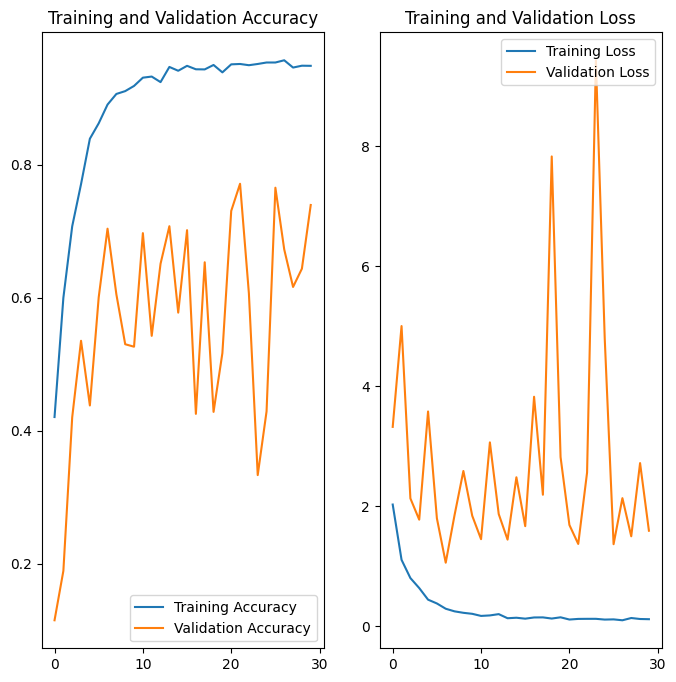

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



###Findings:
There is major difference between Traning accuracy and Validation accuracy.
1. Traning accuracy the model around 94 %
2. Validation accuracy the model around 64 %
3. Rectifying the Class Imbalance and performing Data augumentation on the dataset has resulted in a model with higher accuracy but still there is   overfitting. Some more fine tuning required this